## Exploratory Data Analysis
Performed by Evan Klein, 11/10/2025

In [105]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
train = pd.read_csv('data/application_train.csv')
train.describe()

## There is a lot of data here - we can sample to do some studies without wasting compute or time.
train = train.sample(10_000)

Oh my god, there's a lot of columns. We need to break down what's going on here based on column type.

In [107]:
numerical_columns = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
categorical_columns = [col for col in train.columns if train[col].dtype == 'object']

print(f'Numeric columns: {len(numerical_columns)}')
print(f'Categorical columns: {len(categorical_columns)}')
if len(train.dtypes) == len(numerical_columns) + len(categorical_columns):
    print('All categories accounted for here.')

Numeric columns: 106
Categorical columns: 16
All categories accounted for here.


For our categorical variables, how many distinct values in each?

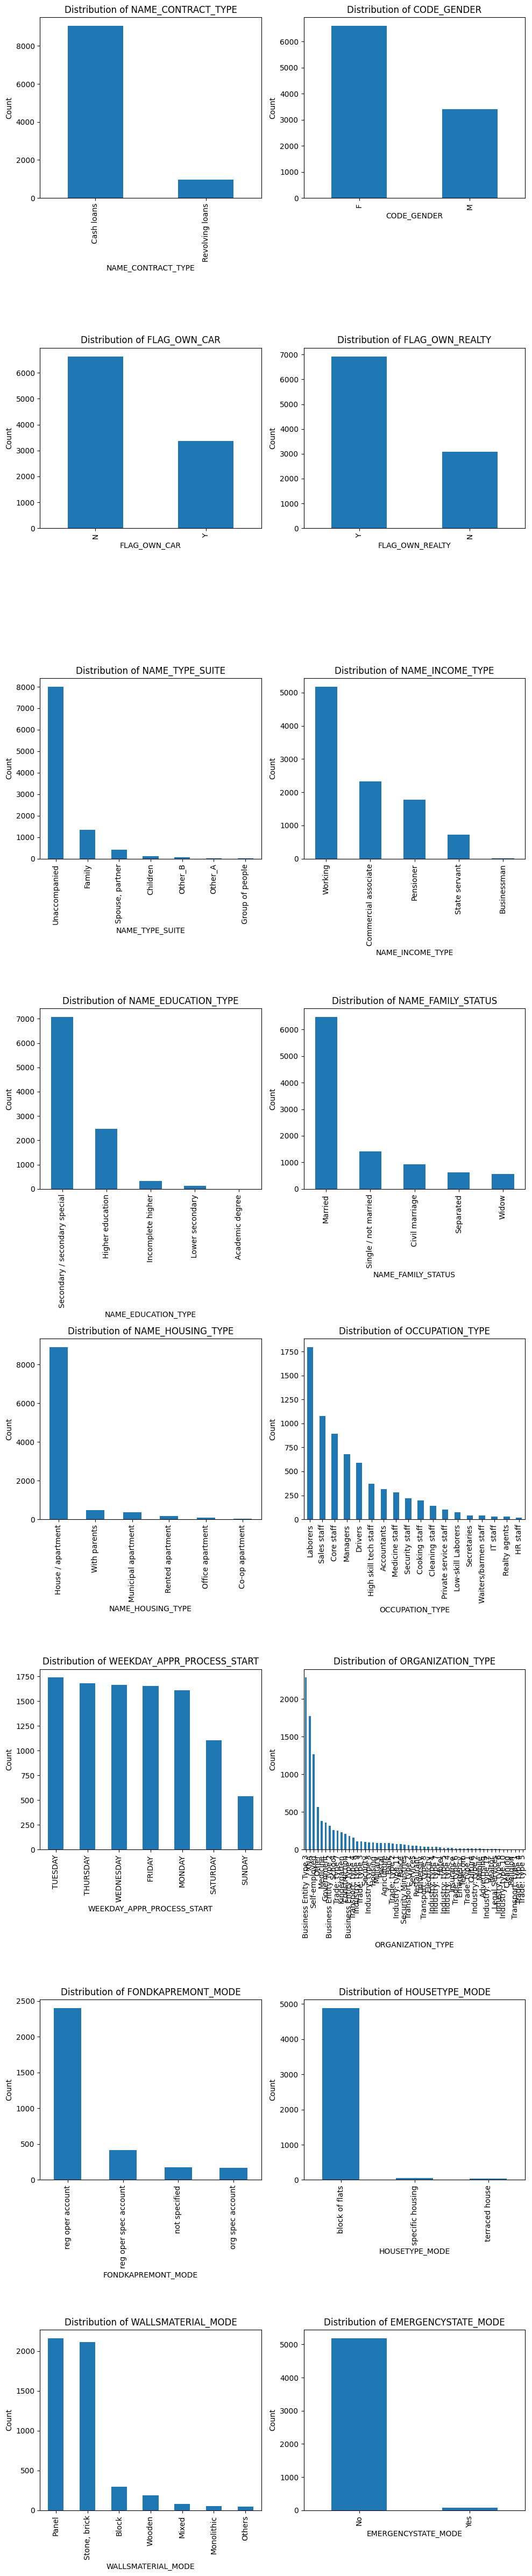

In [108]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(categorical_columns)) / 2), ncols = 2, figsize=(10, 3 * len(categorical_columns)))
axes = axes.flatten()
for i, col in enumerate(categorical_columns):
    train[col].value_counts().plot(kind='bar', ax = axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Count')
    
plt.tight_layout()
plt.show()


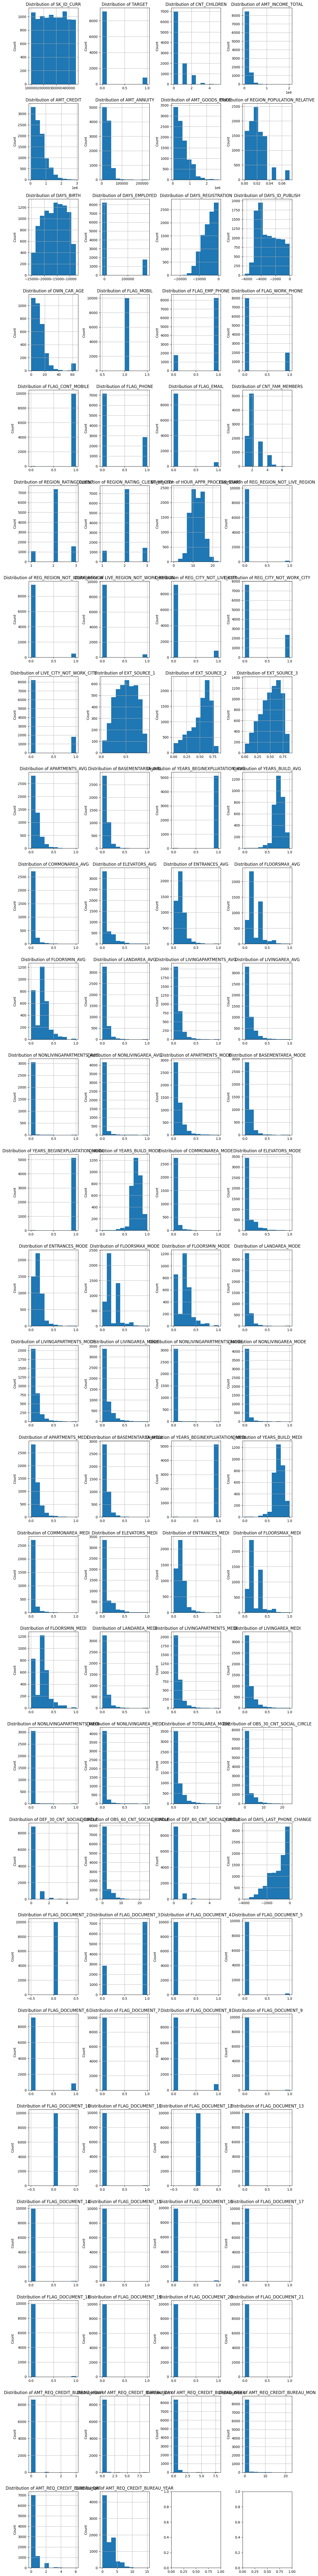

In [109]:
fig, axes = plt.subplots(nrows = int(np.ceil(len(numerical_columns)) / 4) + 1, ncols = 4, figsize=(12, 1 * len(numerical_columns)))
axes = axes.flatten()
for i, col in enumerate(numerical_columns):
    train[col].hist(ax = axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

We have a good idea of our distributions at this point. Let's cleanup our data and split into $X$, $y$.

In [110]:
y = train['TARGET']
X = train.drop(columns = ['SK_ID_CURR']) # Drop ID, as it's just identifier info on the loan app.

X = pd.get_dummies(X) # Convert categorical variables into OHE.

Now we need to evaluate our dataset for missing variables, which might wreak some havoc later down the line. Handling this now will save us some time later.

In [111]:
X = X.fillna(X.median())

Let's build an understand of correlations within our dataset. We can do this by calculating correlation heatmaps using `seaborn` to build an understand of collinearity within our dataset.

<Axes: >

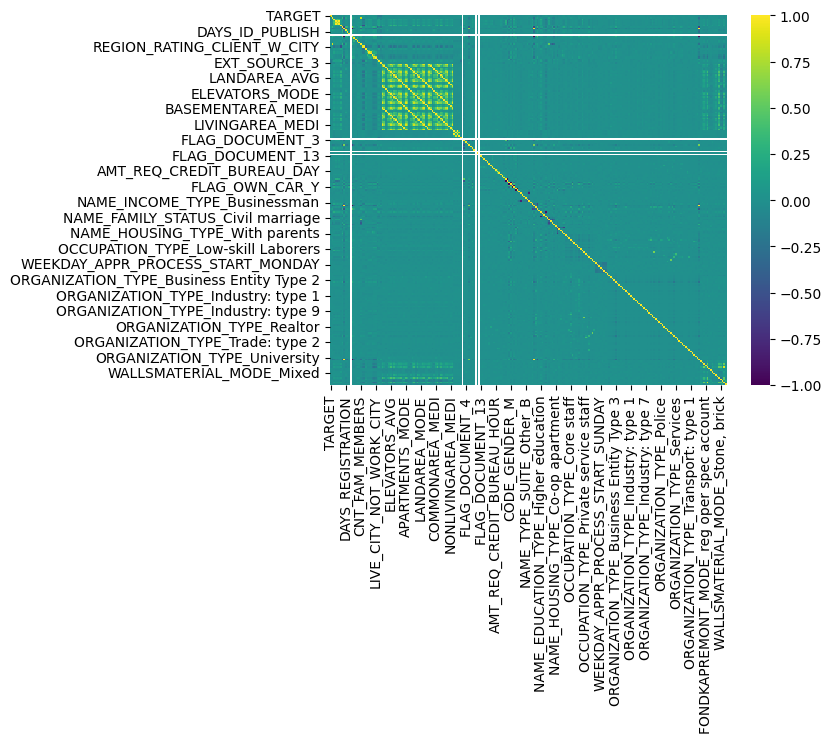

In [112]:
X_corr = X.corr()
sns.heatmap(X_corr, cmap = 'viridis')

We simply have too many variables to study at this point, and this is data from only `application_train.csv`. It doesn't factor in the myriad of data from our additional database tables, such as the ones documenting previous loans, credit history, payment history. Let's work on some methods that will help us visualize the high dimensional data and narrow down the amount of features we need to use.

Before we move onto additional preprocessing, we need to drop `TARGET` from $X$, as it's outlived its usefulness here as part of the initial EDA.

In [113]:
X = X.drop(columns = ['TARGET'])

Perform some standard scaling, as future sections (such as principal component analysis) are going to require nice standardized data.

In [114]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(X)

Let's perform some naive pre-processing, including converting our categorical data to one-hot encoded variants.

### PCA

With so many columns, it might be useful to try to understand how our highly-dimensional data can be better understood and explained. We can study the explained variance and explained variance ratio to understood if our data is truly high-dimensional, or if we can maybe perform some feature engineering as part of our pre-processing steps in order to pare down the large number of features.

Text(0.5, 1.0, 'Explained Variance of Each Principal Component')

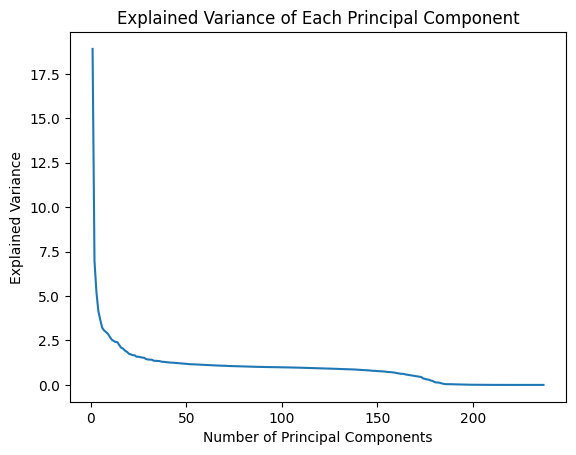

In [115]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_std)

plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_)
plt.ylabel('Explained Variance')
plt.xlabel('Number of Principal Components')
plt.title('Explained Variance of Each Principal Component')

Text(0.5, 1.0, 'Cumulative Sum of Explained Variance')

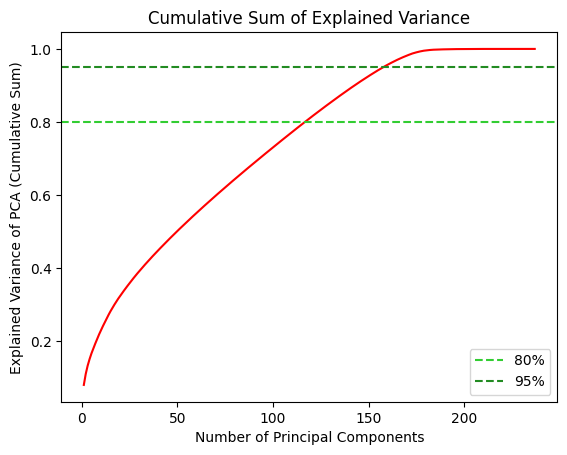

In [116]:
explained_var_cumsum = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1, len(pca.explained_variance_) + 1), explained_var_cumsum, color = 'red')
plt.axhline(0.8, color = 'limegreen', linestyle = '--', label = '80%')
plt.axhline(0.95, color = 'forestgreen', linestyle = '--', label = '95%')
plt.ylabel('Explained Variance of PCA (Cumulative Sum)')
plt.xlabel('Number of Principal Components')
plt.legend()
plt.title('Cumulative Sum of Explained Variance')

So our data actually is very highly dimensional. Scaling out PCA to the full number of features reveals a very gradual curve, showing us that our target is really probably an aggregate of all features rather than a subset of a few. We can still eliminate a number of features from our model with a very small effect on any created models down the road.

## A round of feature variance removal

Okay, we have too many features still. We need a tradeoff here - we're going to have to lose some features at the risk of making the eventual models less reliable. At this point this is a risk I'm personally willing to take, as I'm willing to bet there's a good amount of features that can be eliminated strictly from a variance standpoint.

In [117]:
from sklearn.feature_selection import VarianceThreshold
variance_threshold = VarianceThreshold()
X_reduced = variance_threshold.fit_transform(X_std)
print(f'# of features before: {X_std.shape[1]}, after: {X_reduced.shape[1]}')

# of features before: 237, after: 233


Hm.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

select_k = SelectKBest(f_classif, k = 50)
X_reduced = select_k.fit_transform(X_std, y)

X_reduced.shape

/Users/evan/GitHub/p556-final/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [11 78 86 88] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/evan/GitHub/p556-final/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


(10000, 50)

### t-SNE



In [146]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components = 2, learning_rate = 'auto', init = 'pca', perplexity = 35).fit_transform(X_reduced)

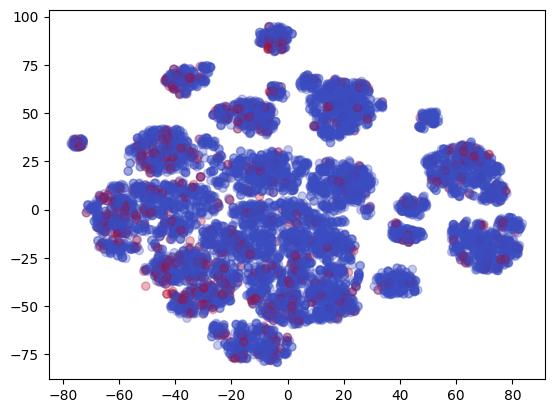

In [147]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y, alpha = 0.3, cmap = 'coolwarm')